In [1]:
# Copyright © 2018-2021 Intel Corporation All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#   * Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in
#     the documentation and/or other materials provided with the
#     distribution.
#   * Neither the name of Intel Corporation nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Legal Information

This document contains the general insights and opinions of Intel Corporation (“Intel”). The information in this document is provided for information only and is not to be relied upon for any other purpose than educational. Intel makes no representations or warranties regarding the accuracy or completeness of the information in this document. Intel accepts no duty to update this document based on more current information. Intel is not liable for any damages, direct or indirect, consequential or otherwise, that may arise, directly or indirectly, from the use or misuse of the information in this document.

Intel technologies’ features and benefits depend on system configuration and may require enabled hardware, software or service activation. Learn more at intel.com, or from the OEM or retailer.

No computer system can be absolutely secure.  No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document.  Intel, the Intel logo, Core, and Xeon are trademarks of Intel Corporation in the United States and other countries.  
*Other names and brands may be claimed as the property of others

Copyright © 2018-2021 Intel Corporation.

# Power and Performance measurements on Loihi solving sequential MNIST

This jupyter notebook shows how the power and performance numbers for a network solving sequential MNIST on Loihi were measured and processed.

For further information on the problem and the network please take a look at the tutorial smnist_tutorial.ipynb in the lsnn/tutorials folder.

In order to run this jupyter notebook one needs access to the NxSDK framework and a Loihi system. 


In [2]:
%config IPCompleter.greedy=True
import sys
sys.path.append('/home/pplank/nxsdk-nxsdk-submission/nxsdk-nxsdk')
import os
import numpy as np
import matplotlib.pyplot as plt

import nxsdk.api.n2a as nx
from nxsdk_modules.lsnn.apps.seqmnist.seq_img_classifier import SequentialImageClassifierLsnn
from nxsdk_modules.lsnn.apps.seqmnist.benchmark.smnist_benchmark import SequentialImageClassifierLsnn_bench
from nxsdk_modules.lsnn.apps.seqmnist.seq_mnist import loadMnistData, loadWeightsAndDelays, showWeights, showImgs
from nxsdk_modules.lsnn.apps.seqmnist.benchmark.smnist_benchmark import performBenchmark, plotResultTable
from nxsdk.utils.env_var_context_manager import setEnvWithinContext
from nxsdk.api.enums.api_enums import ProbeParameter
from nxsdk.graph.monitor.probes import PerformanceProbeCondition

In [3]:
def runSequentialMnist(wgtDir, numSamples, batchSize, numCores=1):
    """Sets up and executes SequentialImageClassifier LSNN network to\
        classify MNIST images on the test set. Used for benchmarking.

        :param string wgtDir: directory which contains the weight matrices for\
        the network
        :param int numSamples: amount of images which should be processed
        :param int batchSize: batchSize of the SequentialImageClassifierLsnn
        :param int numCores: amount of cores the network should be copied
        """

    # Specify data directory
    dataDir = os.path.join('/home/pplank/nxsdk-nxsdk/nxsdk_modules/lsnn/apps/seqmnist/weights', wgtDir)
    # MNIST images are 28 x 28 in size
    imgDx = imgDy = 28

    # Load input, recurrent and output layer weights
    wIn, wRec, wOut = loadWeightsAndDelays(dataDir)

    # Initialize LSSN network
    sqic = SequentialImageClassifierLsnn_bench(wIn=wIn, wRec=wRec, wOut=wOut,
                                               numInput=80, numRegular=140,
                                               numAdaptive=100, numOutput=10,
                                               cueDuration=56,
                                               imageSize=imgDx * imgDy,
                                               batchSize=batchSize,
                                               numCores=numCores)

    sqic.snipsDir = os.path.join('/home/pplank/nxsdk-nxsdk-clean/nxsdk-nxsdk/nxsdk_modules/lsnn/apps/seqmnist/benchmark/snips')

    # Load a random set of MNIST test set images and pass to LSNN
    inputs, targets = loadMnistData('test')
    np.random.seed(0)
    imgIdx = np.random.choice(range(0, 10000), numSamples, False)
    inputs, targets = inputs[imgIdx, :], targets[imgIdx]
    
    # setup some probes
    probeParams = [nx.ProbeParameter.COMPARTMENT_VOLTAGE]
    probeCond = nx.IntervalProbeCondition(dt=1, tStart=1)

    sqic.generateNetwork()

    eProbe = sqic.board.probe(
        probeType=ProbeParameter.ENERGY,
        probeCondition=PerformanceProbeCondition(
            tStart=1,
            tEnd=numSamples * 840,
            bufferSize=1024,
            binSize=200))
    
    # Execute network: Generates spikes from images and injects into LSNN
    sqic.classify(inputs, targets)

    return eProbe, sqic.board, sqic

In [4]:
# name of the folder with the trainend weights
wgtDirName = 'v25_94per'

In [5]:
with setEnvWithinContext(BOARD='ncl-ghrd-01'):
    # Execute network: Generates spikes from images and injects into LSNN
    numSamples = 200  # run 200 images
    etProbe, board, sqic = runSequentialMnist(wgtDirName, numSamples=numSamples,
                                batchSize=10, numCores=1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.22:37219
INFO:DRV:      Host server up..............Done 0.24s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
INFO:DRV:      Compiling Embedded snips....Done 0.64s
INFO:DRV:      Compiling MPDS Registers....Done 0.95ms
INFO:DRV:      Compiling Register Probes...Done 0.74ms
INFO:DRV:      Compiling Spike Probes......Done 0.68ms
INFO:HST:  Args chip=0 cpu=0 /home/pplank/lava_env/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1627677888.408643/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 --epoch=0 --cpu-active-ratio=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.71s
INFO:DRV:      Encoding probes.............Done 0.83ms
INFO:DRV:      Transferring probes.........Done 8.77ms
INFO:DRV:      Configuring registers.......Done 0.07s
INFO:DRV:      Transferring spikes.........Done 0.70ms
[==========] 100%
INFO:DRV:      Executing...................Done 0.03s
INFO:

In [6]:
# Show results
sqic.printClassification()

Classification accuracy of 200 samples: 94.50%


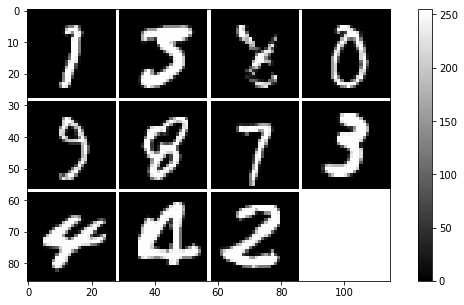

Target labels:  [1 3 8 0 9 8 7 3 4 4 2]
Predicted labels:  [7 5 5 8 3 0 9 2 8 0 3]


In [7]:
# some wrong classifications
# get idx of misclassified images
idx_list = np.where(sqic.targets != sqic.classifications)[0]

# show the target images
target_img = sqic.inputs[idx_list]

showImgs(target_img, 28, 28)
print("Target labels: ", sqic.targets[idx_list])
print("Predicted labels: ", sqic.classifications[idx_list])

In [8]:
# calculate power and performance 
runtime = 840*numSamples  # total number of exeucted time steps 
total = etProbe.totalTimePerTimeStep[0:runtime]  # time series of total time per time step
host = etProbe.hostTimePerTimeStep[0:runtime]  # time series of host time per time step

effective = total - host  # time series of effective time per time step (on Loihi chip)
latency = np.sum(effective) / numSamples  # mean latency of classifying one image

print('Total number of time steps: ', runtime)
print('Total time (µs):', np.sum(effective))
print('Mean time per time step (µs):', np.mean(effective))
print('Time per inference (µs) ({} samples): {}'.format(numSamples, np.sum(effective) / numSamples))
print()
# calculate the energy-delay-product (EDP)
stats = board.energyTimeMonitor.powerProfileStats

n_dynamic = stats['power']['core']['dynamic']
n_static = stats['power']['core']['static']

x86_dynamic = stats['power']['lakemont']['dynamic']
x86_static = stats['power']['lakemont']['static']

dynamic = n_dynamic + x86_dynamic
static = n_static + x86_static

total = dynamic + static
energy = latency * total / 10**6
edp = energy * latency / 1000

print("Dynamic power (mW): ", dynamic)
print("Static power (mW): ", static)
print("Total power (mW): ", total)
print()
print("Latency per inference (ms): ", latency / 1000)
print("Total Energy per inference (mJ): ", energy)
print("EDP (µJs): ", edp)
print()

print("Power in detail:")
print("x86 static power (mW): ", x86_static)
print("x86 dynamic power (mW): ", x86_dynamic)
print("Core static power (mW): ", n_static)
print("Core dynamic power (mW): ", n_dynamic)

Total number of time steps:  168000
Total time (µs): 2797112.0000001984
Mean time per time step (µs): 16.649476190477372
Time per inference (µs) (200 samples): 13985.560000000993

Dynamic power (mW):  24.778585421177354
Static power (mW):  1.1553919470152128
Total power (mW):  25.933977368192565

Latency per inference (ms):  13.985560000000993
Total Energy per inference (mJ):  0.362701196521525
EDP (µJs):  5.0725793460239395

Power in detail:
x86 static power (mW):  0.1490041932759066
x86 dynamic power (mW):  23.195124828751943
Core static power (mW):  1.0063877537393062
Core dynamic power (mW):  1.5834605924254124
